C:\Users\Handiko\AppData\Local\Temp\ipykernel_19180\4236686735.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Fetching data for EURUSD=X from 2015-01-01 to 2025-01-01...
Plot saved successfully to C:\Users\Handiko\PyCharmMiscProject\EURUSD=X_seasonality_chart.png
Displaying the seasonality chart.


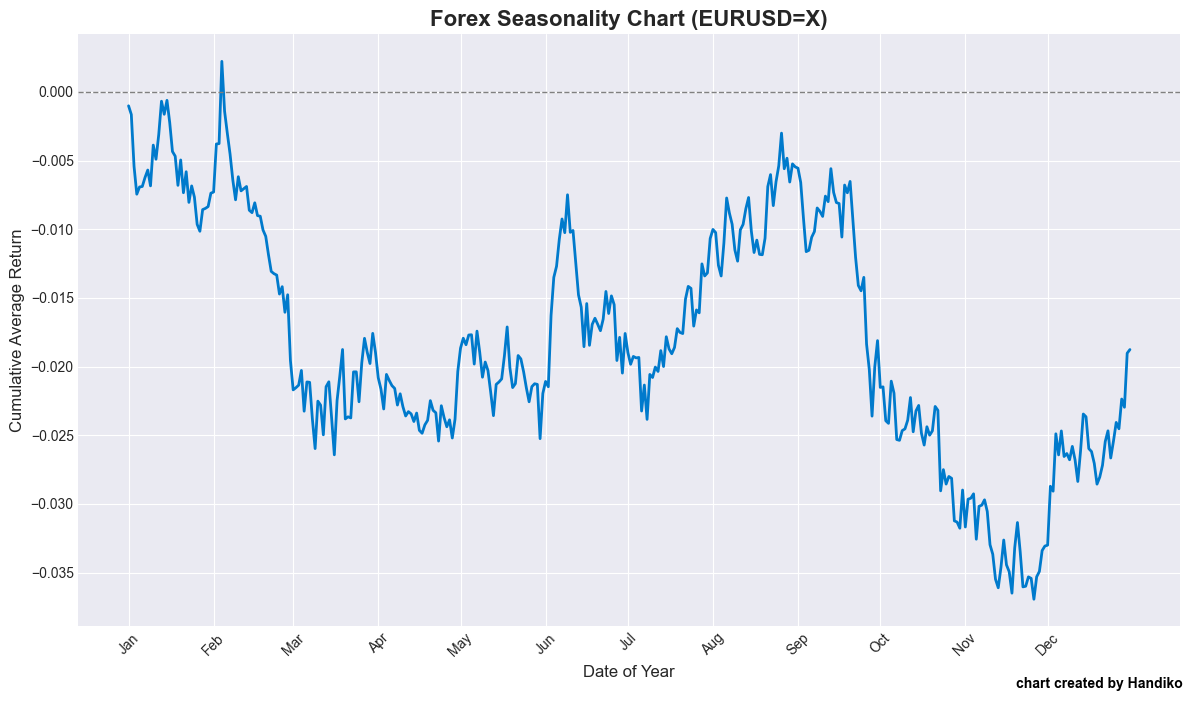

In [35]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Define the forex pair and the date range for the analysis
# Note: 'EURUSD=X' is a common Yahoo Finance ticker for the EUR/USD pair.
TICKER = 'EURUSD=X'
START_DATE = '2015-01-01'
END_DATE = '2025-01-01'
SAVE_PATH = f'./{TICKER}_seasonality_chart.png'

def fetch_data(ticker, start, end):
    """
    Fetches historical forex data from Yahoo Finance.

    Args:
        ticker (str): The ticker symbol for the forex pair.
        start (str): The start date in 'YYYY-MM-DD' format.
        end (str): The end date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: A DataFrame containing the fetched data.
    """
    print(f"Fetching data for {ticker} from {start} to {end}...")
    try:
        data = yf.download(ticker, start=start, end=end)
        if data.empty:
            print(f"No data found for {ticker} in the specified range. Please check the ticker symbol.")
            return None
        return data
    except Exception as e:
        print(f"An error occurred while fetching data: {e}")
        return None

def calculate_seasonality(data):
    """
    Calculates the average daily return for each date of the year and
    the cumulative return curve.

    Args:
        data (pd.DataFrame): A DataFrame with 'Close' prices.

    Returns:
        pd.DataFrame: A DataFrame with the seasonality index and cumulative return.
    """
    # Calculate daily returns
    data['Daily Return'] = data['Close'].pct_change()

    # Drop the first row which will have a NaN value and create an explicit copy
    data = data.dropna().copy()

    # Extract month and day from the index to group by date
    data['Month'] = data.index.month
    data['Day'] = data.index.day

    # Calculate the average daily return for each unique date (month-day)
    average_daily_returns = data.groupby(['Month', 'Day'])['Daily Return'].mean()

    # Create a new DataFrame for the seasonality index
    seasonality_df = pd.DataFrame(average_daily_returns)
    seasonality_df.index = [f"{m:02d}-{d:02d}" for m, d in seasonality_df.index]

    # Calculate the cumulative sum of the average daily returns
    seasonality_df['Cumulative Return'] = (1 + seasonality_df['Daily Return']).cumprod() - 1

    return seasonality_df

def plot_seasonality(seasonality_df, ticker, save_path=None):
    """
    Plots the forex seasonality chart and optionally saves it to a file.

    Args:
        seasonality_df (pd.DataFrame): DataFrame containing the cumulative returns.
        ticker (str): The ticker symbol to use in the chart title.
        save_path (str, optional): The file path to save the plot. Defaults to None.
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(12, 7))

    # Plotting the cumulative returns
    plt.plot(seasonality_df['Cumulative Return'], color='#007acc', linewidth=2)

    # Adding a horizontal line at y=0 for reference
    plt.axhline(0, color='grey', linestyle='--', linewidth=1)

    # Adding title and labels
    plt.title(f'Forex Seasonality Chart ({ticker})', fontsize=16, fontweight='bold')
    plt.xlabel('Date of Year', fontsize=12)
    plt.ylabel('Cumulative Average Return', fontsize=12)

    # Customizing x-axis ticks to show month labels
    # We'll show a tick for the start of each month
    month_starts = [i for i, date_str in enumerate(seasonality_df.index) if date_str.endswith('-01')]
    month_labels = [datetime.strptime(date_str, '%m-%d').strftime('%b') for date_str in seasonality_df.index if date_str.endswith('-01')]
    plt.xticks(month_starts, month_labels, rotation=45)

    plt.grid(True)
    plt.tight_layout()

    # Add the signature text at the bottom right
    plt.figtext(0.99, 0.01, 'chart created by Handiko', horizontalalignment='right', fontsize=10, color='black', fontweight='bold')

    # Save the plot if a save path is provided
    if save_path:
        try:
            plt.savefig(save_path)
            print(f"Plot saved successfully to {os.path.abspath(save_path)}")
        except Exception as e:
            print(f"An error occurred while saving the plot: {e}")

    print("Displaying the seasonality chart.")
    plt.show()

def main():
    """Main function to run the seasonality analysis."""
    data = fetch_data(TICKER, START_DATE, END_DATE)

    if data is not None:
        seasonality_data = calculate_seasonality(data)
        plot_seasonality(seasonality_data, TICKER, SAVE_PATH)

if __name__ == "__main__":
    main()
